In [3]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sys.path.append('../')
from src.functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']]
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()


df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url'], axis=1).drop_duplicates()

df_country =  pd.read_sql_query("SELECT * FROM country_continent", conn)
df_country = df_country[['country_name', 'continent_name']]
df_country = df_country.drop_duplicates('country_name', keep='first')
df_identifiers = pd.merge(df_identifiers, df_country, on = 'country_name', how = 'left')

df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = df_ind_identifiers.drop('identifier_name', axis=1)
df_ind_identifiers = pd.merge(df_ind_identifiers, df_identifiers, on = 'identifiers_wikidata_id', how = 'left')

df_final = pd.merge(df_individual, df_ind_identifiers, on = 'individual_wikidata_id', how = 'left')
df_final = pd.merge(df_final, df_individual_region, on = 'individual_wikidata_id')

df_final = df_final[~df_final['birthyear'].isna()]
df_final['decade'] = df_final['birthyear'].apply(lambda x : int(x/10)*10)

df_fig = df_final[['individual_wikidata_id', 'decade', 'identifier_name', 'country_name', 'region_name']]
df_fig = df_fig.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()

ModuleNotFoundError: No module named 'src'

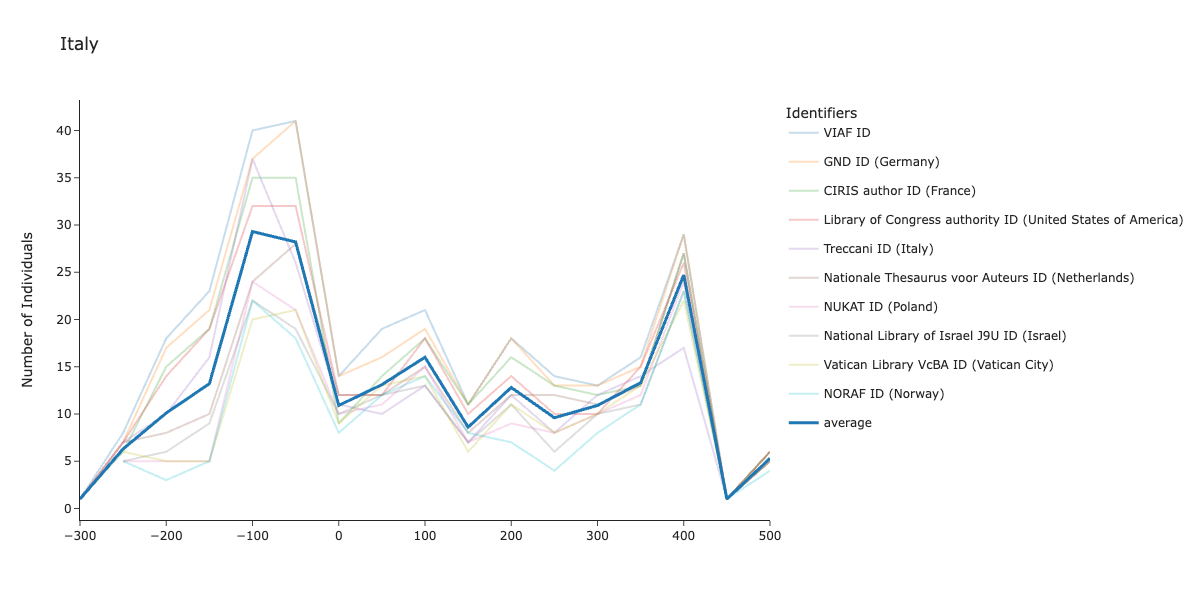

In [ ]:
def make_figure(df_graph_bis, region_name, min_decade = 1200, max_decade = 1800, top_identifiers = 5):

    df_fig = df_graph_bis[df_graph_bis['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]

    one_id_country = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
    one_id_country = one_id_country.sort_values(['country_name', 'score'], ascending=(False, False))
    one_id_country = one_id_country.groupby('country_name').head(1)
    one_id_country = list(one_id_country['identifier_name'])

    df_fig = df_fig[df_fig['identifier_name'].isin(one_id_country)]
    top_ids = df_fig.groupby(['identifier_name'])['score'].sum().reset_index().sort_values('score', ascending=False)

    #top_ids = top_ids[top_ids['identifier_name']!='all_identifiers']
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    df_fig_mean = df_fig.groupby(['decade'])['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    #df_fig = pd.concat([df_fig, df_fig_mean])

    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'identifier_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white',
                  category_orders={'identifier_name': top_ids})
                 #line_shape='spline')


    #fig.update_layout(legend=dict(title=dict(text='Top 5 Immaterial Production')))
    fig.update_traces(opacity=0.25)

    fig2 = px.line(df_fig_mean, x = 'decade', y = 'score',color = 'identifier_name',
              width = 1200, 
              height = 600, 
              title = region_name, 
              template = 'simple_white')  
                   #line_shape='spline')

    fig2.update_traces(line=dict(width=3))
    fig3 = go.Figure(data=fig.data + fig2.data)
    fig3.update_layout(xaxis_title='', yaxis_title='Number of Individuals',  
                       template = 'simple_white',  
                       width = 1200, 
                       height = 600,
                      title = region_name)

# Update the layout with the category order


    #ig3.for_each_trace(lambda t: t.update(name=legend_order.index(t.name)))
    fig3.update_layout(legend=dict(title=dict(text='Identifiers')))
    #fig3.update_layout(category_orders={'Identifiers': top_ids})
    fig3.update_layout(xaxis=dict(dtick=100))

    return fig3

region_name = 'Italy'

df_fig_fifty = df_fig.copy()
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x : round(x/50)*50)
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x : round(x/50)*50)
df_fig_fifty = df_fig_fifty.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['score'].sum().reset_index()

fig3 = make_figure(df_fig_fifty, region_name = region_name, min_decade = -300, max_decade = 500, top_identifiers = 10)

fig3.show()
#fig3.write_image(f"graph_18_05/{region_name}_identifiers.png", scale=7)

In [ ]:
df_final_all = df_final.drop(['identifiers_wikidata_id', 'identifier_name'], axis=1).drop_duplicates()
df_final_all['identifier_name'] = 'all_identifiers'

df_graph_bis =  pd.concat([df_final, df_final_all])
df_graph_bis = df_graph_bis.dropna()

df_graph_bis['decade'] = df_graph_bis['birthyear'].apply(lambda x : int(x/10)*10)
df_graph_bis = df_graph_bis.groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()

In [ ]:
test = df_final[['identifier_name', 'country_name', 'continent_name']].drop_duplicates().dropna()

In [ ]:
df_final_region = df_final.groupby(['region_name', 'decade', 'continent_name'])['individual_wikidata_id'].count().rename('score').reset_index()
df_final_region = df_final_region[~df_final_region['continent_name'].isna()]

In [ ]:
def make_continent_figure(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800,  continent = ['Asia']):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig = df_fig[df_fig['continent_name'].isin(continent)]
    df_fig['score'] = df_fig.groupby('continent_name')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    
    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'continent_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Identifiers Continent')))
    fig.update_layout(xaxis=dict(dtick=100))
    fig.update_layout(xaxis_title='', yaxis_title='Normalised Score')
    
    return fig

In [ ]:
df_final_region_fifty = df_final_region.copy()
df_final_region_fifty['decade'] = df_final_region_fifty['decade'].apply(lambda x: int(x/50)*50)
df_final_region_fifty = df_final_region_fifty.groupby(['region_name', 'decade', 'continent_name'])['score'].sum().reset_index()
df_final_region_fifty = df_final_region_fifty[df_final_region_fifty['continent_name']!='Africa']

In [ ]:
fig = make_continent_figure(df_final_region_fifty,region_name = 'Chinese world', min_decade = -500, max_decade = 1800,  continent = all_continents)
fig.show()

In [ ]:
df_identifiers_new = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers_new = df_identifiers_new[['identifier_name', 'country_name']].copy()
df_identifiers_new['country_name'][df_identifiers_new['country_name'].isna()]=''
#df_identifiers_new = df_identifiers_new.rename(columns = {'identifier_name':'old_identifier_name'})
df_identifiers_new['identifier_name'] = df_identifiers_new.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)


In [ ]:
df_graph_bis = pd.merge(df_graph_bis,df_identifiers_new, on = 'identifier_name')

In [ ]:
set(df_graph_bis[df_graph_bis['country_name']=='Netherlands'].identifier_name)

In [ ]:
#for region_name in list(set(df_graph_bis['region_name']))[:10]:


In [ ]:
df_count = df_final[['decade', 'region_name', 'individual_wikidata_id']].drop_duplicates()
df_count = df_count.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().rename('score').reset_index()
df_count['type'] = 'count'
df_sum = df_final.groupby(['decade', 'region_name'])['identifiers_wikidata_id'].count().rename('score').reset_index()
df_sum['type'] = 'sum'
df_graph = pd.concat([df_count, df_sum])
#df_count['decade'] = df_count['decade'].apply(lambda x: int(x/50)*50)
#df_count = df_count.groupby(['region_name', 'decade'])['score'].sum().reset_index()

In [ ]:
def make_figure_comparison(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig['score'] = df_fig.groupby('type')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    
    fig = px.line(df_fig, 
                  x = 'decade', 
                  y = 'score',
                  color = 'type',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Score Type')))
    fig.update_layout(xaxis=dict(dtick=100))
    
    return df_fig, fig

In [ ]:
df_fig, fig = make_figure_comparison(df_graph, region_name = 'Chinese world', min_decade = -500, max_decade = 1800)

In [ ]:
import sys
sys.path.append('../')
from functions_environment import get_population
data_path_environment = '../data_env'

df_population_decade = get_population(data_path_environment)
df_population_decade = df_population_decade.rename(columns={'year':'decade'})

In [ ]:
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_regions = df_individual_region[['region_code', 'region_name']].drop_duplicates()

In [ ]:
df_trend = pd.merge(df_count, df_regions, on = 'region_name')
df_trend = pd.merge(df_trend, df_population_decade, on =['region_code', 'decade'])
df_trend['score_capita'] = df_trend['score']/df_trend['population']


In [ ]:
#set(df_count.region_name)

In [ ]:
# russian world?

In [ ]:
set(df_trend.region_name)

In [ ]:
df_trend.to_csv('data_to_r/df_individual_trend.csv')

In [ ]:
import numpy as np

In [ ]:
def make_score_per_capita(df, region_name = 'Low countries', min_decade = 1200, max_decade = 1800):

    df_fig = df[df['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    df_fig['score_capita'] = np.log(1 + df_fig['score_capita'])
    #df_fig['score'] = df_fig.groupby('continent_name')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 9 + 1)
    fig = px.line(df_fig, x = 'decade', y = 'score_capita',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white')
                  #line_shape='spline')
    
    fig.update_layout(legend=dict(title=dict(text='Identifiers Continent')))
    fig.update_layout(xaxis=dict(dtick=100))
    fig.update_layout(xaxis_title='', yaxis_title='Log Score per Capita')
    
    return fig

In [ ]:
region_name = 'Japan'
fig = make_score_per_capita(df_trend, region_name = region_name, min_decade = -500, max_decade = 1850)
fig.show()
fig.write_image(f"graph_18_05/{region_name}_cultural_score.png", scale=7)